In [1]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft2, irfft2
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

y, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None

with h5py.File(h5_files[1], "r") as data:
    y = data["y"][100:]
    Hs = data.attrs["Hs"]
    Tp = data.attrs["Tp"]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

index = 0

In [2]:
eta_hat = y[:121, 0].copy()
phi_hat = y[:121, 1]

X, Y = np.meshgrid(x, x)
mask = ((X-1500)**2+(Y-1500)**2) <= 200**2
mask_2 = ((X-1500)**2+(Y-1500)**2) < 1500**2

mask_i_left = []
mask_i_right = []
mask_i = []
mask_j = []

I, J = np.meshgrid(np.arange(0, 2*modes), np.arange(0, 2*modes))
for i in range(2*modes):
    for j in range(2*modes):
        if not mask[i, j]:
            continue

        for k in range(modes):
            if not mask[modes+k, j]:
                mask_i.append(i)
                mask_j.append(j)
                mask_i_left.append(modes+k)
                mask_i_right.append(modes-k-1)
                break

mask_2_i = []
mask_2_j = []
mask_2_i_map = []
mask_2_j_map = []
for j in range(2*modes):
    for i in range(modes):
        if mask_2[i, j]: continue
        for k in range(modes):
            if mask_2[i+k, j]:
                mask_2_i.append(i)
                mask_2_j.append(j)
                mask_2_i_map.append(i+k)
                mask_2_j_map.append(j)
                break

for j in range(2*modes):
    for i in range(modes, 2*modes):
        if mask_2[i, j]: continue
        for k in range(modes):
            if mask_2[i-k, j]:
                mask_2_i.append(i)
                mask_2_j.append(j)
                mask_2_i_map.append(i-k)
                mask_2_j_map.append(j)
                break

mask_i = np.array(mask_i)
mask_j = np.array(mask_j)
mask_i_left = np.array(mask_i_left)
mask_i_right = np.array(mask_i_right)

mask_2_i = np.array(mask_2_i)
mask_2_j = np.array(mask_2_j)
mask_2_i_map = np.array(mask_2_i_map)
mask_2_j_map = np.array(mask_2_j_map)

eta = irfft2(eta_hat).astype(np.float32)
eta[:, mask_i, mask_j] = (eta[:, mask_i_left, mask_j] + eta[:, mask_i_right, mask_j])*0.5
eta[:, mask_2_i, mask_2_j] = eta[:, mask_2_i_map, mask_2_j_map]
eta_hat = rfft2(eta).astype(np.complex64)

indexes = np.concatenate((np.arange(0, modes+1), np.arange(2, modes+1)[::-1]))
mask_vert = indexes < 202+1
mask_hor = np.arange(0, modes+1) < 202+1
eta_hat[:, ~mask_vert, :] = 0
eta_hat[:, :, ~mask_hor] = 0

In [7]:
import jax
import jax.numpy as jnp
from HOSim import solver

for idx, sigma in enumerate(np.arange(0, 0.65, 0.05)):
    eta = irfft2(eta_hat).astype(np.float32)

    f_jit = jax.jit(solver.f2d, static_argnums=(2, 3, 4, 5, 6))
    rk4_step_jit = solver.rk4_step

    eta_hat_0 = jnp.asarray(eta_hat[0])
    phi_hat_0 = jnp.zeros_like(eta_hat_0, dtype=jnp.complex64)

    y_hat = jnp.stack([eta_hat_0, phi_hat_0])
    k0 = 2 * np.pi / length

    L1 = np.ones(eta_hat_0.shape[-2:])*1
    L1[0, 0] = 0
    ky = np.arange(0, modes+1)*k0
    kx = np.concatenate((ky, -ky[1:-1][::-1]))
    KX, KY = jnp.meshgrid(kx, ky, indexing="ij")
    K = np.sqrt(KX**2 + KY**2)
    L2 = 1.0 / K - 9.81
    L2[0, 0] = 0

    y_hat = y_hat.at[0, 31:-31, :].set(0)
    y_hat = y_hat.at[1, 31:-31, :].set(0)

    sim_10_sec = 9
    y_saved = np.zeros((sim_10_sec*20+1, *y_hat.shape), dtype=np.complex64)
    y_saved[0] = y_hat

    for i in range(sim_10_sec):
        for j in range(1, 401):
            y_hat = rk4_step_jit(200, y_hat, 0.025, modes, 9.81, k0, 4, 0.001, f_jit)
            y_hat = y_hat.at[0, 31:-31, :].set(0)
            y_hat = y_hat.at[1, 31:-31, :].set(0)

            if j % 40 == 0:
                y_obs = irfft2(y[i*10+j//40, 0])+np.random.normal(0, sigma, size=(2*modes, 2*modes))
                y_obs[mask] = irfft2(y_hat[0])[mask]
                y_obs[~mask_2] = irfft2(y_hat[0])[~mask_2]
                y_obs_hat = rfft2(y_obs)

                y_obs_hat[0, 0] = 0
                y_obs_hat[~mask_vert, :] = 0
                y_obs_hat[:, ~mask_hor] = 0
                
                y_hat = y_hat.at[0].add(1.0 * L1 * (y_obs_hat - y_hat[0]))
                y_hat = y_hat.at[1].add(1.0 * L2 * (y_obs_hat - y_hat[0]))
                y_hat = y_hat.at[:, 0, 0].set(0)

                # plt.plot(irfft2(y_hat[0])[modes, :])
                # plt.plot(irfft2(y[i*10+j//40, 0])[modes, :])
                # plt.show()

            if j % 20 == 0:
                y_saved[i*20+j//20] = y_hat
                print(f"{(i*20+j//20)/(sim_10_sec*20+1)*100:.1f}%")

    np.save(f'y_observer_{idx}_sigma_{sigma:.3f}.npy', y_saved)
    print("saved:", f'y_observer_{idx}_sigma_{sigma:.3f}.npy')

C:\Users\Vegard\AppData\Local\Temp\ipykernel_25772\2908964472.py:23: RuntimeWarning: divide by zero encountered in divide
  L2 = 1.0 / K - 9.81


0.6%
1.1%
1.7%
2.2%
2.8%
3.3%
3.9%
4.4%
5.0%
5.5%
6.1%
6.6%
7.2%
7.7%
8.3%
8.8%
9.4%
9.9%
10.5%
11.0%
11.6%
12.2%
12.7%
13.3%
13.8%
14.4%
14.9%
15.5%
16.0%
16.6%
17.1%
17.7%
18.2%
18.8%
19.3%
19.9%
20.4%
21.0%
21.5%
22.1%
22.7%
23.2%
23.8%
24.3%
24.9%
25.4%
26.0%
26.5%
27.1%
27.6%
28.2%
28.7%
29.3%
29.8%
30.4%
30.9%
31.5%
32.0%
32.6%
33.1%
33.7%
34.3%
34.8%
35.4%
35.9%
36.5%
37.0%
37.6%
38.1%
38.7%
39.2%
39.8%
40.3%
40.9%
41.4%
42.0%
42.5%
43.1%
43.6%
44.2%
44.8%
45.3%
45.9%
46.4%
47.0%
47.5%
48.1%
48.6%
49.2%
49.7%
50.3%
50.8%
51.4%
51.9%
52.5%
53.0%
53.6%
54.1%
54.7%
55.2%
55.8%
56.4%
56.9%
57.5%
58.0%
58.6%
59.1%
59.7%
60.2%
60.8%
61.3%
61.9%
62.4%
63.0%
63.5%
64.1%
64.6%
65.2%
65.7%
66.3%
66.9%
67.4%
68.0%
68.5%
69.1%
69.6%
70.2%
70.7%
71.3%
71.8%
72.4%
72.9%
73.5%
74.0%
74.6%
75.1%
75.7%
76.2%
76.8%
77.3%
77.9%
78.5%
79.0%
79.6%
80.1%
80.7%
81.2%
81.8%
82.3%
82.9%
83.4%
84.0%
84.5%
85.1%
85.6%
86.2%
86.7%
87.3%
87.8%
88.4%
89.0%
89.5%
90.1%
90.6%
91.2%
91.7%
92.3%
92.8%
93.4%
93.9

KeyboardInterrupt: 

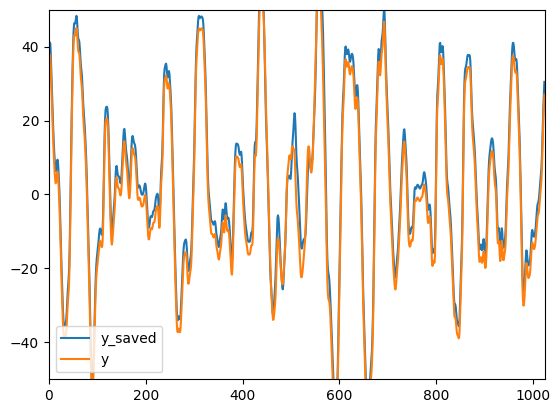

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from numpy.fft import irfft2

fig, ax = plt.subplots()
line1, = ax.plot([], [], label='y_saved')
line2, = ax.plot([], [], label='y')
ax.set_xlim(0, 1024)
ax.set_ylim(-5*10, 5*10)

def update(frame):
    ys1 = irfft2(y_saved[frame*2, 1])[modes, :]
    ys2 = irfft2(y[frame, 1])[modes, :]

    x = np.arange(len(ys1))
    line1.set_data(x, ys1)
    line2.set_data(x, ys2)
    ax.legend(loc=3)
    return line1, line2

ani = FuncAnimation(fig, update, frames=(y_saved.shape[0]-1)//2+1, blit=True)
ani.save("comparison.gif", dpi=80, writer="pillow")
plt.show()

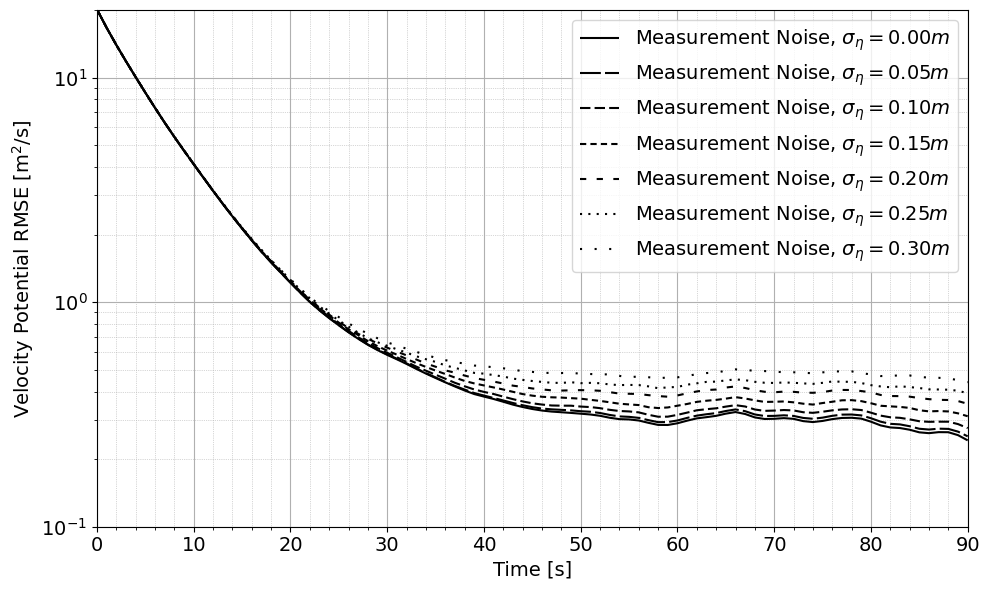

In [40]:
phi_mask = ~mask & mask_2

linestyles = [
    (0, ()),               # solid
    (0, (10, 2)),          # long dashes
    (0, (5, 2)),           # medium dashes
    (0, (3, 2)),           # shorter dashes
    (0, (3, 5)),           # spaced short dashes
    (0, (1, 3)),           # dots
    (0, (1, 6)),           # very spaced dots
]

fig, ax = plt.subplots(figsize=(10, 6))
phi_hat_actual = irfft2(y[:91, 1])
for idx in range(7):
    data = np.load(f'y_observer_{idx}_sigma_{idx*0.05:.3f}.npy')
    phi_hat_saved = irfft2(data[::2, 1])
    
    error = np.mean(np.abs(phi_hat_saved[:, phi_mask] - phi_hat_actual[:, phi_mask]), axis=-1)
    plt.semilogy(error, color="k", label=fr"Measurement Noise, $\sigma_{{\eta}}={0.05*idx:.2f}m$", linestyle=linestyles[idx])
# plt.plot(np.mean(np.abs(phi_hat_saved[:, mask] - phi_hat_actual[:, mask]), axis=-1))
# plt.axhline(error[-1])
fontsize=14
ax.legend(fontsize=fontsize, loc=1)
ax.grid(True, which='major', linewidth=0.8)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax.tick_params(labelsize=fontsize)
plt.xlabel("Time [s]", fontsize=fontsize)
plt.ylabel(fr"Velocity Potential RMSE [m$^2$/s]", fontsize=fontsize)
plt.ylim(10**(-1), 2*10**(1))
plt.xlim(0, 90)
plt.tight_layout()
plt.savefig("results/observer_error_time.pdf", dpi=300, bbox_inches='tight')
plt.show()

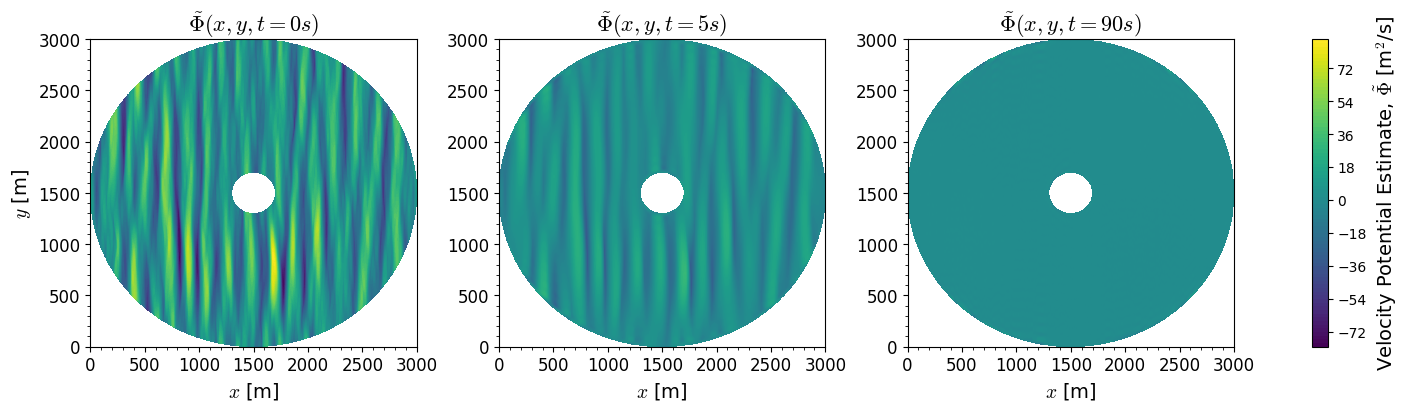

In [26]:
import matplotlib

matplotlib.rcParams.update({
    "text.usetex": False,             # Use built-in mathtext, not full LaTeX
    "mathtext.fontset": "cm",         # Use Computer Modern for math
    "font.family": "sans-serif",      # Default text font (you can change this)
    "font.sans-serif": ["DejaVu Sans"]  # This is matplotlib's default
})

phi_hat_actual = irfft2(y[:91, 1])

fontsize = 14

time = [0, 5, 90]

X, Y = np.meshgrid(x, x)
mask = ((X-1500)**2+(Y-1500)**2) <= 200**2
mask_2 = ((X-1500)**2+(Y-1500)**2) < 1500**2

idx = 0
data = np.load(f'y_observer_{idx}_sigma_{idx*0.05:.3f}.npy')
phi_hat_saved = irfft2(data[::2, 1])

error = phi_hat_actual - phi_hat_saved
error[:, mask] = np.nan
error[:, ~mask_2] = np.nan

phi_hat_actual_contour = phi_hat_actual[-1].copy()
phi_hat_actual_contour[mask] = np.nan
phi_hat_actual_contour[~mask_2] = np.nan

vmin = np.nanmin(error)
vmax = np.nanmax(error)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
for i in range(3):
    cf = axes[i].contourf(x, x, error[time[i]], levels=100, vmin=vmin, vmax=vmax, cmap='viridis')
    cf.set_zorder(1)
    axes[i].set_rasterization_zorder(1)
    axes[i].set_title(fr"$\tilde{{\Phi}}(x, y, t={time[i]}s)$", fontsize=fontsize+2)
    axes[i].set_xlabel(fr"$x$ [m]", fontsize=fontsize)
    axes[i].set_axisbelow(True)  # Put gridlines below all plot elements
    # axes[i].grid(True, which='major', linewidth=0.8, zorder=-1)
    axes[i].minorticks_on()
    # axes[i].grid(True, which='minor', linestyle=':', linewidth=0.5, zorder=-1)
    axes[i].tick_params(labelsize=fontsize-2)
    
    if i == 0:
        axes[i].set_ylabel(fr"$y$ [m]", fontsize=fontsize)
        cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), orientation='vertical')
        cbar.set_label(fr"Velocity Potential Estimate, $\tilde{{\Phi}}$ [m$^2$/s]", fontsize=fontsize)

plt.savefig("results/observer_time_2d.pdf", dpi=300, bbox_inches='tight')
plt.show()